In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則創建它
    weights_dir = os.path.join(os.getcwd(), f"weights_KD_segformer_0501test_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

def test_model(model, image_processor, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # load the model weight which is the best and saved during training process
    model.load_state_dict(torch.load('weights_only_segformer\segformer_data_size_5.pth'))
    model.to(device)
    model.eval()

    total_loss = 0.0
    with torch.no_grad():
        for image, mask in test_loader:
            image, mask = image.to(device), mask.to(device)
            inputs = image_processor(images=image, return_tensors="pt").to(device)
            outputs = model(**inputs).logits
            outputs = F.interpolate(outputs, size=mask.size()[2:], mode='bilinear', align_corners=False)

            loss = criterion(outputs, mask)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f"Average test loss: {avg_loss}")
    return avg_loss

def showSegmentationResult(model, test_loader, num_images=1):
    plt.figure(figsize=(16, num_images * 5))
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for idx, (image, mask) in enumerate(test_loader):
        if idx >= num_images:
            break
        image, mask = image.to(device), mask.to(device)
        outputs = model(image)
        labels = torch.squeeze(torch.argmax(outputs['out'].cpu(), dim=1)).numpy()

        # Original Image
        plt.subplot(num_images, 4, idx * 4 + 1)
        plt.imshow(np.transpose(torch.squeeze(image).cpu().numpy(), (1, 2, 0)))
        plt.axis(False)
        plt.title('Original Image')

        # Ground Truth Label
        plt.subplot(num_images, 4, idx * 4 + 2)
        plt.imshow(mask[:,0,:,:].permute(1, 2, 0).cpu().numpy())
        plt.axis(False)
        plt.title('Ground Truth Label')
        
        # Model Prediction
        plt.subplot(num_images, 4, idx * 4 + 3)
        plt.imshow(labels)
        plt.axis(False)
        plt.title('Model Prediction')

        # Overlay Prediction on Original Image
        plt.subplot(num_images, 4, idx * 4 + 4)
        overlay = image.cpu().squeeze().permute(1, 2, 0).numpy()
        red_channel = overlay[:, :, 0]
        red_channel[labels == 1] = 255  # 將預測為1的區域設為紅色
        overlay[:, :, 0] = red_channel
        plt.imshow(overlay)
        plt.axis(False)
        plt.title('Overlay Prediction on Original Image')

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        teacher_ratio = 1
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 12s 893ms/step - loss: 5.9019e-05
Average validation loss: 0.8363160490989685
4/4 [==============================] - 12s 905ms/step - loss: 5.9019e-05 - val_loss: 0.8363
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_100\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 15s 791ms/step - loss: 5.7338e-05 - val_loss: 0.8363
Average validation loss: 0.7250972986221313
4/4 [==============================] - 15s 808ms/step - loss: 5.7338e-05 - val_loss: 0.7807
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_100\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 19s 795ms/step - loss: 5.5678e-05 - val_loss: 0.7807
Average validation loss: 0.8218074440956116
4/4 [==============================] - 19s 810ms/step - loss: 5.5678e-05 - val_loss: 0.7944
Epoch 4/10
4/4 [=================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 737ms/step - loss: 1.0959e-04
Average validation loss: 3.9131736755371094
8/8 [==============================] - 6s 751ms/step - loss: 1.0959e-04 - val_loss: 3.9132
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_100\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 12s 726ms/step - loss: 1.1138e-04 - val_loss: 3.9132
Average validation loss: 0.09844271093606949
8/8 [==============================] - 12s 737ms/step - loss: 1.1138e-04 - val_loss: 2.0058
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_100\segformer_data_size_10.pth'.
Epoch 3/10
8/8 [==============================] - 18s 720ms/step - loss: 1.1082e-04 - val_loss: 2.0058
Average validation loss: 1.3897830843925476
8/8 [==============================] - 18s 732ms/step - loss: 1.1082e-04 - val_loss: 1.8005
Epoch 4/10
8/8 [================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 9s 718ms/step - loss: 1.2900e-04
Average validation loss: 0.07383431494235992
12/12 [==============================] - 9s 729ms/step - loss: 1.2900e-04 - val_loss: 0.0738
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_100\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 18s 726ms/step - loss: 1.2269e-04 - val_loss: 0.0738
Average validation loss: 1.1041903893152873
12/12 [==============================] - 18s 737ms/step - loss: 1.2269e-04 - val_loss: 0.5890
Epoch 3/10
12/12 [==============================] - 26s 719ms/step - loss: 1.1827e-04 - val_loss: 0.5890
Average validation loss: 0.06433780601946637
12/12 [==============================] - 26s 732ms/step - loss: 1.1827e-04 - val_loss: 0.4141
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_100\segformer_data_size_15.pth'.
Epoch 4/10
12/12 [=

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 12s 716ms/step - loss: 1.4876e-04
Average validation loss: 0.7134325057268143
16/16 [==============================] - 12s 729ms/step - loss: 1.4876e-04 - val_loss: 0.7134
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_100\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 23s 717ms/step - loss: 1.3622e-04 - val_loss: 0.7134
Average validation loss: 0.20263927429914474
16/16 [==============================] - 23s 730ms/step - loss: 1.3622e-04 - val_loss: 0.4580
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_100\segformer_data_size_20.pth'.
Epoch 3/10
16/16 [==============================] - 35s 708ms/step - loss: 1.3280e-04 - val_loss: 0.4580
Average validation loss: 0.2572169117629528
16/16 [==============================] - 35s 722ms/step - loss: 1.3280e-04 - val_loss: 0.3911
Epoch 4/10
16/16 [

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 14s 724ms/step - loss: 1.0002e-04
Average validation loss: 0.29975867867469785
20/20 [==============================] - 15s 737ms/step - loss: 1.0002e-04 - val_loss: 0.2998
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_100\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 29s 717ms/step - loss: 9.8604e-05 - val_loss: 0.2998
Average validation loss: 0.5193812310695648
20/20 [==============================] - 29s 728ms/step - loss: 9.8604e-05 - val_loss: 0.4096
Epoch 3/10
20/20 [==============================] - 44s 713ms/step - loss: 9.8527e-05 - val_loss: 0.4096
Average validation loss: 0.5882017582654953
20/20 [==============================] - 44s 725ms/step - loss: 9.8527e-05 - val_loss: 0.4691
Epoch 4/10
20/20 [==============================] - 58s 716ms/step - loss: 9.6616e-05 - val_loss: 0.4691
Average validation loss: 0.18588050082325935
20/20 [==

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 17s 717ms/step - loss: 8.1770e-05
Average validation loss: 1.1334863503774006
24/24 [==============================] - 17s 727ms/step - loss: 8.1770e-05 - val_loss: 1.1335
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_100\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 35s 717ms/step - loss: 7.9844e-05 - val_loss: 1.1335
Average validation loss: 1.0135499437650044
24/24 [==============================] - 35s 729ms/step - loss: 7.9844e-05 - val_loss: 1.0735
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_100\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 52s 710ms/step - loss: 7.7743e-05 - val_loss: 1.0735
Average validation loss: 0.3397819995880127
24/24 [==============================] - 52s 721ms/step - loss: 7.7743e-05 - val_loss: 0.8289
Saved model weights

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 29s 715ms/step - loss: 7.4093e-05
Average validation loss: 0.18133391067385674
40/40 [==============================] - 29s 726ms/step - loss: 7.4093e-05 - val_loss: 0.1813
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_100\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 58s 714ms/step - loss: 7.4491e-05 - val_loss: 0.1813
Average validation loss: 0.6615605175495147
40/40 [==============================] - 58s 725ms/step - loss: 7.4491e-05 - val_loss: 0.4214
Epoch 3/10
40/40 [==============================] - 87s 714ms/step - loss: 7.5009e-05 - val_loss: 0.4214
Average validation loss: 3.720292401313782
40/40 [==============================] - 87s 725ms/step - loss: 7.5009e-05 - val_loss: 1.5211
Epoch 4/10
40/40 [==============================] - 116s 714ms/step - loss: 7.4795e-05 - val_loss: 1.5211
Average validation loss: 1.3179266095161437
40/40 [===

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 34s 712ms/step - loss: 5.3736e-05
Average validation loss: 0.4873809777200222
48/48 [==============================] - 35s 723ms/step - loss: 5.3736e-05 - val_loss: 0.4874
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_100\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 69s 714ms/step - loss: 5.0087e-05 - val_loss: 0.4874
Average validation loss: 1.0027559796969097
48/48 [==============================] - 70s 726ms/step - loss: 5.0087e-05 - val_loss: 0.7451
Epoch 3/10
48/48 [==============================] - 104s 712ms/step - loss: 4.9592e-05 - val_loss: 0.7451
Average validation loss: 0.7926455742369095
48/48 [==============================] - 104s 723ms/step - loss: 4.9592e-05 - val_loss: 0.7609
Epoch 4/10
48/48 [==============================] - 138s 712ms/step - loss: 4.9582e-05 - val_loss: 0.7609
Average validation loss: 0.6071882136166096
48/48 [=

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 40s 712ms/step - loss: 4.9712e-05
Average validation loss: 0.8710385404992849
56/56 [==============================] - 41s 724ms/step - loss: 4.9712e-05 - val_loss: 0.8710
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_100\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 80s 712ms/step - loss: 4.2288e-05 - val_loss: 0.8710
Average validation loss: 1.186181936945234
56/56 [==============================] - 81s 723ms/step - loss: 4.2288e-05 - val_loss: 1.0286
Epoch 3/10
56/56 [==============================] - 121s 715ms/step - loss: 3.9643e-05 - val_loss: 1.0286
Average validation loss: 0.8543111612754208
56/56 [==============================] - 122s 726ms/step - loss: 3.9643e-05 - val_loss: 0.9705
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_100\segformer_data_size_70.pth'.
Epoch 4/10
56/56 [

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 46s 712ms/step - loss: 3.7386e-05
Average validation loss: 0.9932065713219345
64/64 [==============================] - 46s 724ms/step - loss: 3.7386e-05 - val_loss: 0.9932
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_100\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 92s 712ms/step - loss: 3.6674e-05 - val_loss: 0.9932
Average validation loss: 4.2286340364662465
64/64 [==============================] - 93s 724ms/step - loss: 3.6674e-05 - val_loss: 2.6109
Epoch 3/10
64/64 [==============================] - 138s 711ms/step - loss: 3.5053e-05 - val_loss: 2.6109
Average validation loss: 1.793442377820611
64/64 [==============================] - 139s 723ms/step - loss: 3.5053e-05 - val_loss: 2.3384
Epoch 4/10
64/64 [==============================] - 185s 713ms/step - loss: 3.3715e-05 - val_loss: 2.3384
Average validation loss: 1.5630938448011875
64/64 [==

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 56s 781ms/step - loss: 2.9771e-05
Average validation loss: 1.478489425447252
72/72 [==============================] - 57s 793ms/step - loss: 2.9771e-05 - val_loss: 1.4785
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_100\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 114s 782ms/step - loss: 2.7948e-05 - val_loss: 1.4785
Average validation loss: 1.7593757775094774
72/72 [==============================] - 114s 794ms/step - loss: 2.7948e-05 - val_loss: 1.6189
Epoch 3/10
72/72 [==============================] - 170s 778ms/step - loss: 2.6758e-05 - val_loss: 1.6189
Average validation loss: 2.148361643155416
72/72 [==============================] - 171s 790ms/step - loss: 2.6758e-05 - val_loss: 1.7954
Epoch 4/10
72/72 [==============================] - 227s 777ms/step - loss: 2.6459e-05 - val_loss: 1.7954
Average validation loss: 1.4582634783453412
72/72 [=

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 63s 782ms/step - loss: 3.2686e-05
Average validation loss: 1.8849768072366715
80/80 [==============================] - 64s 795ms/step - loss: 3.2686e-05 - val_loss: 1.8850
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_100\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 126s 780ms/step - loss: 2.8339e-05 - val_loss: 1.8850
Average validation loss: 1.369288331270218
80/80 [==============================] - 127s 793ms/step - loss: 2.8339e-05 - val_loss: 1.6271
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_100\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 190s 786ms/step - loss: 2.7076e-05 - val_loss: 1.6271
Average validation loss: 1.2983353912830353
80/80 [==============================] - 191s 798ms/step - loss: 2.7076e-05 - val_loss: 1.5175
Saved model we

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 69s 715ms/step - loss: 2.9658e-05
Average validation loss: 1.9651618997255962
96/96 [==============================] - 70s 727ms/step - loss: 2.9658e-05 - val_loss: 1.9652
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_100\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 139s 717ms/step - loss: 2.6945e-05 - val_loss: 1.9652
Average validation loss: 2.087647462884585
96/96 [==============================] - 140s 729ms/step - loss: 2.6945e-05 - val_loss: 2.0264
Epoch 3/10
96/96 [==============================] - 209s 719ms/step - loss: 2.5663e-05 - val_loss: 2.0264
Average validation loss: 1.870415637890498
96/96 [==============================] - 210s 730ms/step - loss: 2.5663e-05 - val_loss: 1.9744
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_100\segformer_data_size_120.pth'.
Epoch 4/10
96/9

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 86s 718ms/step - loss: 4.3655e-05
Average validation loss: 2.056384634971619
120/120 [==============================] - 88s 729ms/step - loss: 4.3655e-05 - val_loss: 2.0564
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_100\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 174s 721ms/step - loss: 4.2695e-05 - val_loss: 2.0564
Average validation loss: 1.2856465617815653
120/120 [==============================] - 175s 732ms/step - loss: 4.2695e-05 - val_loss: 1.6710
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_100\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 262s 718ms/step - loss: 4.0403e-05 - val_loss: 1.6710
Average validation loss: 1.913757586479187
120/120 [==============================] - 263s 730ms/step - loss: 4.0403e-05 - val_loss: 1.7519
Epo

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 104s 720ms/step - loss: 4.7277e-05
Average validation loss: 1.1596442539658811
144/144 [==============================] - 105s 731ms/step - loss: 4.7277e-05 - val_loss: 1.1596
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_100\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 208s 713ms/step - loss: 4.2354e-05 - val_loss: 1.1596
Average validation loss: 0.9497827548119757
144/144 [==============================] - 210s 725ms/step - loss: 4.2354e-05 - val_loss: 1.0547
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_100\segformer_data_size_180.pth'.
Epoch 3/10
144/144 [==============================] - 313s 715ms/step - loss: 3.9209e-05 - val_loss: 1.0547
Average validation loss: 0.8548439236150848
144/144 [==============================] - 314s 726ms/step - loss: 3.9209e-05 - val_loss: 0.9881

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 115s 721ms/step - loss: 3.9640e-05
Average validation loss: 1.3216091729700565
160/160 [==============================] - 117s 732ms/step - loss: 3.9640e-05 - val_loss: 1.3216
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_100\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 232s 717ms/step - loss: 3.4997e-05 - val_loss: 1.3216
Average validation loss: 1.7879521310329438
160/160 [==============================] - 234s 728ms/step - loss: 3.4997e-05 - val_loss: 1.5548
Epoch 3/10
160/160 [==============================] - 349s 718ms/step - loss: 3.3050e-05 - val_loss: 1.5548
Average validation loss: 1.1488473755307496
160/160 [==============================] - 351s 729ms/step - loss: 3.3050e-05 - val_loss: 1.4195
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_100\segformer_data_size_200.pth'.

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 144s 719ms/step - loss: 4.4113e-05
Average validation loss: 2.213865389823914
200/200 [==============================] - 146s 731ms/step - loss: 4.4113e-05 - val_loss: 2.2139
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_100\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 290s 720ms/step - loss: 3.8674e-05 - val_loss: 2.2139
Average validation loss: 1.1778462344408036
200/200 [==============================] - 292s 731ms/step - loss: 3.8674e-05 - val_loss: 1.6959
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_100\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 436s 717ms/step - loss: 3.6067e-05 - val_loss: 1.6959
Average validation loss: 1.3242168033123016
200/200 [==============================] - 438s 728ms/step - loss: 3.6067e-05 - val_loss: 1.5720


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:40 - loss: 2.3813e-05

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 172s 718ms/step - loss: 4.4058e-05
Average validation loss: 1.1072610174616178
240/240 [==============================] - 175s 729ms/step - loss: 4.4058e-05 - val_loss: 1.1073
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_100\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 347s 718ms/step - loss: 4.2684e-05 - val_loss: 1.1073
Average validation loss: 1.053186828394731
240/240 [==============================] - 350s 729ms/step - loss: 4.2684e-05 - val_loss: 1.0802
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_100\segformer_data_size_300.pth'.
Epoch 3/10
240/240 [==============================] - 522s 717ms/step - loss: 4.0241e-05 - val_loss: 1.0802
Average validation loss: 1.0632649560769398
240/240 [==============================] - 525s 728ms/step - loss: 4.0241e-05 - val_loss: 1.0746


train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.9262399720400571, 0.6753565499362583, 0.40226997298848205, 0.42108907003027357, 0.575932859621942, 0.6266734255001861, 1.223788519786671, 1.4089970423211347, 1.2075472086062655, 1.5135979496192886, 1.4479992377178537, 1.3455639006793498, 1.4496541683065394, 1.386887694582343, 1.432790371592467, 1.4706563036479057, 1.5170270041391254, 1.3846399829244862]
std_val_losses =  [1.8249713724216172, 0.8343253220316179, 0.38385708007169916, 0.23423913980221214, 0.27993290167995777, 0.3514010512048185, 0.8388989362487391, 0.7952450443931665, 0.3898778474869362, 0.5917840876259433, 0.3984240904899145, 0.31138039243870963, 0.4191742434700634, 0.332839409016869, 0.38195971235261916, 0.3617717904801136, 0.3520546773755756, 0.36907597026888317]


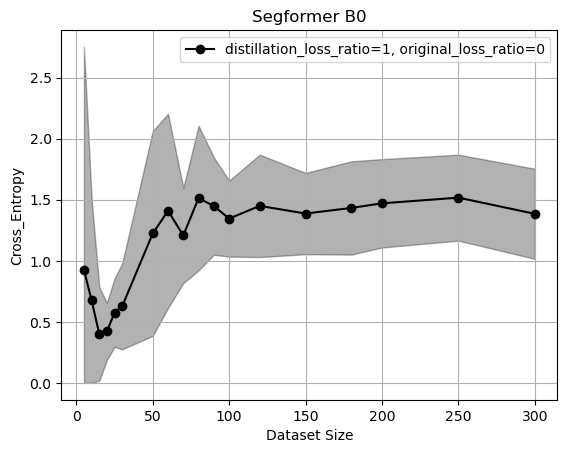

In [2]:
print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.show()